<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/Slope(6months).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
hemo = pd.read_csv('/content/drive/MyDrive/Thesis Project Kidney/Hemodialysis.csv', encoding='latin1')
hemo.shape

(149987, 5)

In [3]:
import pandas as pd
lab = pd.read_csv('/content/drive/MyDrive/Thesis Project Kidney/Lab.csv')
lab.shape

(21641523, 11)



> ***ข้อมูลผู้ป่วยตั้งแต่ 01-12-2557 ถึง 10-04-2566**



In [4]:
# Create a list from hemo['PatientUID']
patient_uid_list = hemo['PatientUID'].unique().tolist()

In [5]:
# Remove patient UIDs from lab['PatientUID'] that are in the list
lab = lab[~lab['PatientUID'].isin(patient_uid_list)]
lab.shape

(17728574, 11)

In [6]:
lab['PatientVisitUID'].nunique() #มีผู้ป่วย 20967 ที่ไม่ฟอกไต เป็นผู้ป่วยที่เราจะใช้

489786

#**🗂️ Patient Data eGFR age >= 18**




In [7]:
# Define the values to match
result_item_names = ['eGFR(CKD-EPI) age >=18']

# Select rows where 'ResultItemName' matches the specified values
eGFR = lab[lab['ResultItemName'].isin(result_item_names)]
eGFR
labeGFR = eGFR[['LabNo','PatientUID', 'PatientVisitUID', 'ResultItemName', 'ResultValue', 'CWhen']]
labeGFR

,LabNo,PatientUID,PatientVisitUID,ResultItemName,ResultValue,CWhen
248,1,2299,3386255,eGFR(CKD-EPI) age >=18,71.7,2559-08-15 09:51:54.913
255,1,2299,3640924,eGFR(CKD-EPI) age >=18,66.8,2559-11-11 09:40:06.053
271,1,2299,4020970,eGFR(CKD-EPI) age >=18,67.20,2560-03-31 10:18:54.363
286,1,2299,4286612,eGFR(CKD-EPI) age >=18,69.20,2560-07-05 10:40:40.763
331,1,2299,4546471,eGFR(CKD-EPI) age >=18,63.60,2560-10-03 09:19:54.710
...,...,...,...,...,...,...
21628049,159,925649,3617725,eGFR(CKD-EPI) age >=18,77.60,2560-04-17 08:54:35.740
21628297,160,925649,3617725,eGFR(CKD-EPI) age >=18,72.00,2560-04-19 08:41:45.060
21628538,161,925649,3617725,eGFR(CKD-EPI) age >=18,62.90,2560-04-21 08:47:03.167
21628775,162,925649,3617725,eGFR(CKD-EPI) age >=18,59.60,2560-04-24 08:59:53.310


> 📌 **See Not Use Result Value**


    eGFR that are not digits and decimal
    there are Not Detect / Cancel etc.

In [8]:
import re
# Define the regular expression pattern for valid values (digits and decimals)
pattern = r'^[0-9]+(\.[0-9]+)?$'

# Filter rows with non-digit or non-decimal values in the 'ResultValue' column
non_digit_rows = labeGFR[~labeGFR['ResultValue'].astype(str).apply(lambda x: bool(re.match(pattern, x)))] #51 rows have eGFR as Not Deteched

In [9]:
import pandas as pd

# Assuming you have a DataFrame named 'eGFR' with the specified columns
pivot_table = pd.pivot_table(labeGFR, index=['PatientUID', 'PatientVisitUID'], values=['ResultItemName', 'ResultValue', 'CWhen'], aggfunc='first')
pivot_table

CWhen          ResultItemName  \
PatientUID PatientVisitUID                                                    
2299       3386255          2559-08-15 09:51:54.913  eGFR(CKD-EPI) age >=18   
           3640924          2559-11-11 09:40:06.053  eGFR(CKD-EPI) age >=18   
           4020970          2560-03-31 10:18:54.363  eGFR(CKD-EPI) age >=18   
           4286612          2560-07-05 10:40:40.763  eGFR(CKD-EPI) age >=18   
           4546471          2560-10-03 09:19:54.710  eGFR(CKD-EPI) age >=18   
...                                             ...                     ...   
3432056    10312896         2566-01-30 16:16:45.013  eGFR(CKD-EPI) age >=18   
           10408954         2566-02-24 21:05:12.747  eGFR(CKD-EPI) age >=18   
           10573233         2566-04-10 09:51:32.587  eGFR(CKD-EPI) age >=18   
3437526    10191122         2565-12-26 09:29:11.307  eGFR(CKD-EPI) age >=18   
           10541118         2566-03-30 18:44:40.160  eGFR(CKD-EPI) age >=18   

                           ResultValue  
PatientUID PatientVisitUID              
2299       3386255                71.7  
           3640924                66.8  
           4020970               67.20  
           4286612               69.20  
           4546471               63.60  
...                                ...  
3432056    10312896              72.86  
           10408954              68.69  
           10573233              45.08  
3437526    10191122              55.94  
           10541118              56.99  

[318686 rows x 3 columns]

#  **🕑 Generate datetime**
    Split CWhen เพราะต้องการ generate year as คศ. Pandas มี outbound
    ให้อยู่ในระยะเวลาของ คศ. แต่ลอง convert column 'CWhen'
    เป็น datetime แล้วทำไม่ได้เลยต้อง split แล้วค่อย merge

In [10]:
import pandas as pd

df = pd.DataFrame(pivot_table)

# Splitting the 'time' column into separate columns
df[['date', 'timestamp']] = df['CWhen'].str.split(' ', expand=True)
df[['year', 'month', 'day']] = df['date'].str.split('-', expand=True)
df[['hour', 'minute', 'second']] = df['timestamp'].str.split(':', expand=True)
df[['second', 'nanosecond']] = df['second'].str.split('.', expand=True)

# Convert year column from BE to AD
df['year'] = df['year'].astype(int) - 543

# Combine columns into a datetime column
df['date'] = pd.to_datetime(df[['year', 'month', 'day',]])
# Convert timestamp to Timedelta
df['timestamp'] = pd.to_timedelta(df['timestamp'])

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Merge timestamp and date columns
df['datetime'] = df['date'] + df['timestamp']

df_sorted = df.sort_values(by=['PatientUID', 'datetime'])

In [11]:
df_sorted = df_sorted[['CWhen','ResultItemName','ResultValue','date','datetime']] #eGFR ทั้งหมดมี 318686 rows


# 📄 **ValidVisitData**
> **VisitID ที่ผ่าน Condition 365 วัน มีทั้งหมด 73592 rows**


In [12]:
df_sorted_reset = df_sorted.reset_index()

In [13]:
df_sorted_reset.columns

Index(['PatientUID', 'PatientVisitUID', 'CWhen', 'ResultItemName',
       'ResultValue', 'date', 'datetime'],
      dtype='object')

In [14]:
import pandas as pd

# Assuming you have df_sorted_reset = df_sorted.reset_index()

validVisitID_list = []
savedDataBTW = {}

for patientID, patient_df in df_sorted_reset.groupby('PatientUID'):
    validVisitID = [patient_df.iloc[0]['PatientVisitUID']]  # Initialize with the first visit
    visitBefore = patient_df.iloc[0]['datetime']

    savedDataBTW[patientID] = {}

    for _, row in patient_df.iloc[1:].iterrows():
        visitNow = row['datetime']
        savedDataBTW[patientID][visitNow] = {
            "PatientVisitUID": row['PatientVisitUID'],  # Include the PatientVisitUID
            "Xtime": [],
            "YeGFR": []
        }

        time = (visitNow - patient_df.iloc[0]['datetime']).days / 182.5
        eGFR = row['ResultValue']
        savedDataBTW[patientID][visitNow]["Xtime"].append(time)
        savedDataBTW[patientID][visitNow]["YeGFR"].append(eGFR)

        if (visitNow - visitBefore).days >= 182.5:
            validVisitID.append(row['PatientVisitUID'])
            visitBefore = visitNow

    validVisitID_list.extend(validVisitID)

# Step 4: Filter the DataFrame based on the validVisitID_list
df_final = df_sorted_reset[df_sorted_reset['PatientVisitUID'].isin(validVisitID_list)]


In [16]:
df_final #ผ่านคอนดิชัน 182.5 วัน มี 113857 rows

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.7,2016-08-15,2016-08-15 09:51:54.913
2,2299,4020970,2560-03-31 10:18:54.363,eGFR(CKD-EPI) age >=18,67.20,2017-03-31,2017-03-31 10:18:54.363
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710
7,2299,5296557,2561-06-21 08:55:47.877,eGFR(CKD-EPI) age >=18,55.00,2018-06-21,2018-06-21 08:55:47.877
11,2299,6082911,2562-03-13 09:13:31.170,eGFR(CKD-EPI) age >=18,73.50,2019-03-13,2019-03-13 09:13:31.170
...,...,...,...,...,...,...,...
318672,3421578,10151787,2565-12-14 11:30:53.310,eGFR(CKD-EPI) age >=18,47.44,2022-12-14,2022-12-14 11:30:53.310
318674,3426284,10105952,2565-11-29 10:47:37.917,eGFR(CKD-EPI) age >=18,27.88,2022-11-29,2022-11-29 10:47:37.917
318676,3431501,10144649,2565-12-13 13:42:48.510,eGFR(CKD-EPI) age >=18,54.65,2022-12-13,2022-12-13 13:42:48.510
318678,3432056,10154545,2565-12-15 09:48:31.117,eGFR(CKD-EPI) age >=18,70.18,2022-12-15,2022-12-15 09:48:31.117


### 📈 **CalculateSlope**


```
same old method
by generate timediff then calculate slope between each patient
```



**Generate TimeDiff Column**

In [17]:
df_final['TimeDiff'] = df_final.groupby('PatientUID')['datetime'].diff().dt.days / 182.5
df_final #fisrt rows of each pateint must be null

<ipython-input-17-055818b524c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['TimeDiff'] = df_final.groupby('PatientUID')['datetime'].diff().dt.days / 182.5


,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.7,2016-08-15,2016-08-15 09:51:54.913,NaN
2,2299,4020970,2560-03-31 10:18:54.363,eGFR(CKD-EPI) age >=18,67.20,2017-03-31,2017-03-31 10:18:54.363,1.249315
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710,1.013699
7,2299,5296557,2561-06-21 08:55:47.877,eGFR(CKD-EPI) age >=18,55.00,2018-06-21,2018-06-21 08:55:47.877,1.424658
11,2299,6082911,2562-03-13 09:13:31.170,eGFR(CKD-EPI) age >=18,73.50,2019-03-13,2019-03-13 09:13:31.170,1.452055
...,...,...,...,...,...,...,...,...
318672,3421578,10151787,2565-12-14 11:30:53.310,eGFR(CKD-EPI) age >=18,47.44,2022-12-14,2022-12-14 11:30:53.310,NaN
318674,3426284,10105952,2565-11-29 10:47:37.917,eGFR(CKD-EPI) age >=18,27.88,2022-11-29,2022-11-29 10:47:37.917,NaN
318676,3431501,10144649,2565-12-13 13:42:48.510,eGFR(CKD-EPI) age >=18,54.65,2022-12-13,2022-12-13 13:42:48.510,NaN
318678,3432056,10154545,2565-12-15 09:48:31.117,eGFR(CKD-EPI) age >=18,70.18,2022-12-15,2022-12-15 09:48:31.117,NaN


In [39]:
df_final #ผ่านคอนดิชัน 182.5 วัน มี 113857 rows

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.70,2016-08-15,2016-08-15 09:51:54.913,NaN,NaN
2,2299,4020970,2560-03-31 10:18:54.363,eGFR(CKD-EPI) age >=18,67.20,2017-03-31,2017-03-31 10:18:54.363,1.249315,-3.601974
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710,1.013699,-3.551351
7,2299,5296557,2561-06-21 08:55:47.877,eGFR(CKD-EPI) age >=18,55.00,2018-06-21,2018-06-21 08:55:47.877,1.424658,-6.036538
11,2299,6082911,2562-03-13 09:13:31.170,eGFR(CKD-EPI) age >=18,73.50,2019-03-13,2019-03-13 09:13:31.170,1.452055,12.740566
...,...,...,...,...,...,...,...,...,...
318672,3421578,10151787,2565-12-14 11:30:53.310,eGFR(CKD-EPI) age >=18,47.44,2022-12-14,2022-12-14 11:30:53.310,NaN,NaN
318674,3426284,10105952,2565-11-29 10:47:37.917,eGFR(CKD-EPI) age >=18,27.88,2022-11-29,2022-11-29 10:47:37.917,NaN,NaN
318676,3431501,10144649,2565-12-13 13:42:48.510,eGFR(CKD-EPI) age >=18,54.65,2022-12-13,2022-12-13 13:42:48.510,NaN,NaN
318678,3432056,10154545,2565-12-15 09:48:31.117,eGFR(CKD-EPI) age >=18,70.18,2022-12-15,2022-12-15 09:48:31.117,NaN,NaN


In [ ]:
df_final['ResultValue'] = pd.to_numeric(df_final['ResultValue'], errors='coerce')
df_final['TimeDiff'] = pd.to_numeric(df_final['TimeDiff'], errors='coerce')
list_of_slopes = [(df_final['ResultValue'].iloc[i+1] - df_final['ResultValue'].iloc[i]) / df_final['TimeDiff'].iloc[i+1] for i in range(len(df_final)-1)]
df_final['Slopes'] = [None] + list_of_slopes

**Minimum - Maximum**

In [30]:
print(df_final['Slopes'].min())  #eGfr จากน้อยไปมาก (5.53-116.46) / 1.07 = -103.28
print(df_final['Slopes'].max())  #eGfr จากมากไปน้อย (114.40-15.0) / 1.03 = 96.49

-103.28941326530611
96.49202127659575


In [27]:
df_final[df_final['PatientUID']==2609014]

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
290490,2609014,4789712,2560-12-27 11:39:20.773,eGFR(CKD-EPI) age >=18,30.80,2017-12-27,2017-12-27 11:39:20.773,NaN,NaN
290495,2609014,5334669,2561-07-04 08:46:39.587,eGFR(CKD-EPI) age >=18,82.10,2018-07-04,2018-07-04 08:46:39.587,1.030137,49.799202
290502,2609014,5934590,2562-01-23 07:29:07.593,eGFR(CKD-EPI) age >=18,132.80,2019-01-23,2019-01-23 07:29:07.593,1.106849,45.805693
290509,2609014,6590892,2562-08-28 07:14:11.683,eGFR(CKD-EPI) age >=18,110.90,2019-08-28,2019-08-28 07:14:11.683,1.183562,-18.503472
290515,2609014,7201894,2563-03-11 07:18:32.967,eGFR(CKD-EPI) age >=18,116.46,2020-03-11,2020-03-11 07:18:32.967,1.073973,5.177041
290521,2609014,7712173,2563-09-23 08:29:25.340,eGFR(CKD-EPI) age >=18,5.53,2020-09-23,2020-09-23 08:29:25.340,1.073973,-103.289413
290528,2609014,8287831,2564-04-07 08:44:02.487,eGFR(CKD-EPI) age >=18,39.36,2021-04-07,2021-04-07 08:44:02.487,1.073973,31.499872
290533,2609014,8920673,2564-11-24 07:47:58.150,eGFR(CKD-EPI) age >=18,76.63,2021-11-24,2021-11-24 07:47:58.150,1.260274,29.572935
290538,2609014,9513546,2565-06-01 07:17:52.177,eGFR(CKD-EPI) age >=18,99.08,2022-06-01,2022-06-01 07:17:52.177,1.030137,21.793218
290541,2609014,10450965,2566-03-08 07:12:44.173,eGFR(CKD-EPI) age >=18,110.36,2023-03-08,2023-03-08 07:12:44.173,1.528767,7.378495


In [29]:
df_final[df_final['PatientUID']==2384626]

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
280816,2384626,3830999,2560-01-23 12:05:42.797,eGFR(CKD-EPI) age >=18,15.00,2017-01-23,2017-01-23 12:05:42.797,NaN,NaN
280832,2384626,4354681,2560-07-31 08:26:23.477,eGFR(CKD-EPI) age >=18,114.40,2017-07-31,2017-07-31 08:26:23.477,1.030137,96.492021
280848,2384626,4936350,2561-02-19 08:21:33.057,eGFR(CKD-EPI) age >=18,100.10,2018-02-19,2018-02-19 08:21:33.057,1.106849,-12.919554
280855,2384626,5559121,2561-09-17 09:49:20.780,eGFR(CKD-EPI) age >=18,107.70,2018-09-17,2018-09-17 09:49:20.780,1.150685,6.604762
280862,2384626,6341111,2562-06-10 09:54:06.290,eGFR(CKD-EPI) age >=18,106.20,2019-06-10,2019-06-10 09:54:06.290,1.457534,-1.029135
280874,2384626,6925899,2562-12-13 07:49:21.250,eGFR(CKD-EPI) age >=18,95.18,2019-12-13,2019-12-13 07:49:21.250,1.013699,-10.871081
280893,2384626,7512277,2563-07-17 09:01:16.757,eGFR(CKD-EPI) age >=18,118.97,2020-07-17,2020-07-17 09:01:16.757,1.189041,20.007719


In [31]:
df_final[df_final['PatientUID']==1291292]

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
215852,1291292,3373047,2559-08-09 10:43:13.040,eGFR(CKD-EPI) age >=18,8.50,2016-08-09,2016-08-09 10:43:13.040,NaN,NaN
215853,1291292,3912591,2560-02-21 11:01:41.153,eGFR(CKD-EPI) age >=18,6.30,2017-02-21,2017-02-21 11:01:41.153,1.073973,-2.048469
215855,1291292,4857687,2561-01-23 09:44:38.420,eGFR(CKD-EPI) age >=18,4.70,2018-01-23,2018-01-23 09:44:38.420,1.835616,-0.871642
215862,1291292,5453853,2561-08-15 09:38:23.120,eGFR(CKD-EPI) age >=18,92.30,2018-08-15,2018-08-15 09:38:23.120,1.112329,78.753695
215867,1291292,6147515,2562-04-03 08:51:52.033,eGFR(CKD-EPI) age >=18,103.40,2019-04-03,2019-04-03 08:51:52.033,1.260274,8.807609
215873,1291292,6900071,2562-12-03 08:38:26.287,eGFR(CKD-EPI) age >=18,86.90,2019-12-03,2019-12-03 08:38:26.287,1.331507,-12.391975
215877,1291292,7548928,2563-07-31 08:18:44.213,eGFR(CKD-EPI) age >=18,94.85,2020-07-31,2020-07-31 08:18:44.213,1.315068,6.045312
215881,1291292,8577949,2564-07-30 08:18:07.030,eGFR(CKD-EPI) age >=18,62.33,2021-07-30,2021-07-30 08:18:07.030,1.989041,-16.349587
215886,1291292,9225143,2565-03-01 08:00:58.437,eGFR(CKD-EPI) age >=18,58.24,2022-03-01,2022-03-01 08:00:58.437,1.167123,-3.504343
215895,1291292,9903667,2565-09-28 08:21:16.913,eGFR(CKD-EPI) age >=18,53.74,2022-09-28,2022-09-28 08:21:16.913,1.156164,-3.892180


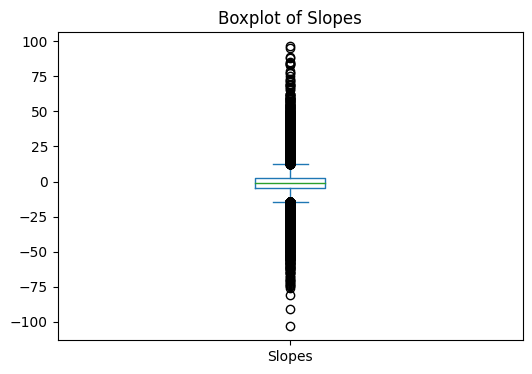

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(df_final)
# Select the column you want to analyze
selected_column = 'Slopes'

# Calculate z-scores for the selected column
z_scores = np.abs((df[selected_column] - df[selected_column].mean()) / df[selected_column].std())

# Set a threshold for outlier detection (e.g., z-score greater than 3)
outlier_threshold = 3

# Detect outliers
outliers = df[z_scores > outlier_threshold]

# Visualize outliers using a box plot
plt.figure(figsize=(6, 4))
df[selected_column].plot.box()
plt.title(f"Boxplot of {selected_column}")
plt.show()


# ✨ **List dfBTW**

In [40]:
timeFrame = 182.5

# Create a collection (dict) to store data between each valid timeDiff
dfBTW = {}

# Loop through each patient group
for patientID, patient_df in df_sorted_reset.groupby('PatientUID'):
    validVisitID = [patient_df.iloc[0]['PatientVisitUID']]  # Initialize with the first visit
    visitBefore = patient_df.iloc[0]['datetime']

    # Create a nested dictionary to store information for this patient "id"
    dfBTW[patientID] = {}

    for index, row in patient_df.iterrows():
        visitNow = row['PatientVisitUID']
        timeVisitNow = row['datetime']

        if (timeVisitNow - visitBefore).days >= timeFrame:
            validVisitID.append(visitNow)
            visitBefore = timeVisitNow  # Update visitBefore with the current visitNow

        # Store eGFR value and time point value
        if visitBefore in dfBTW[patientID]:
            dfBTW[patientID][visitBefore]["eGFR"].append(row["ResultValue"])
            dfBTW[patientID][visitBefore]["timepoint"].append((timeVisitNow - visitBefore).days)
        else:
            dfBTW[patientID][visitBefore] = {
                "eGFR": [row["ResultValue"]],
                "timepoint": [(timeVisitNow - visitBefore).days]
            }

# Perform linear regression on each patient's data
for id, visits in dfBTW.items():
    for visit, data in visits.items():
        if len(data["eGFR"]) > 1:
            time_points = data["timepoint"]
            eGFR_values = data["eGFR"]
            # Perform linear regression using time_points as X and eGFR_values as y
            # You can use libraries like numpy and scipy for regression analysis here
            # The results of the linear regression can be stored in a suitable data structure
            # For example: regression_results = perform_linear_regression(time_points, eGFR_values)


In [41]:
dfBTW[2299] #len(set(dfBTW)) = 20967

{Timestamp('2016-08-15 09:51:54.913000'): {'eGFR': ['71.7', '66.8'],
  'timepoint': [0, 87]},
 Timestamp('2017-03-31 10:18:54.363000'): {'eGFR': ['67.20', '69.20'],
  'timepoint': [0, 96]},
 Timestamp('2017-10-03 09:19:54.710000'): {'eGFR': ['63.60', '58.40', '62.40'],
  'timepoint': [0, 92, 176]},
 Timestamp('2018-06-21 08:55:47.877000'): {'eGFR': ['55.00',
   '64.00',
   '62.40',
   '70.20'],
  'timepoint': [0, 27, 83, 174]},
 Timestamp('2019-03-13 09:13:31.170000'): {'eGFR': ['73.50', '65.40'],
  'timepoint': [0, 98]},
 Timestamp('2019-09-19 08:51:25.673000'): {'eGFR': ['61.90',
   '62.70',
   '64.02',
   '64.92',
   '58.37',
   '54.86'],
  'timepoint': [0, 49, 91, 125, 150, 175]},
 Timestamp('2020-06-04 09:02:32.947000'): {'eGFR': ['59.12', '56.21', '61.48'],
  'timepoint': [0, 83, 111]},
 Timestamp('2020-12-04 09:04:03.177000'): {'eGFR': ['55.14', '48.54'],
  'timepoint': [0, 90]},
 Timestamp('2021-06-21 08:06:49.077000'): {'eGFR': ['55.14', '56.52'],
  'timepoint': [0, 119]},
 Ti

### 📈 **CalculateSlope**

In [42]:
time_points = np.array(time_points, dtype=np.float64)
eGFR_values = np.array(eGFR_values, dtype=np.float64)

In [43]:
import numpy as np
from scipy.stats import linregress

# Perform linear regression on each patient's data
for id, visits in dfBTW.items():
    for visit, data in visits.items():
        if len(data["eGFR"]) > 1:
            time_points = np.array(data["timepoint"], dtype=np.float64)
            eGFR_values = np.array(data["eGFR"])

            # Convert 'ND', 'CC', and '-' to NaN (Not a Number)
            non_numeric_values = ['ND', 'CC', '-','Not detected','nd','r']
            eGFR_values = np.where(np.isin(eGFR_values, non_numeric_values), np.nan, eGFR_values)

            # Convert the array to float after handling non-numeric values
            eGFR_values = eGFR_values.astype(np.float64)

            # Remove rows with NaN values
            valid_indices = ~np.isnan(eGFR_values)
            time_points = time_points[valid_indices]
            eGFR_values = eGFR_values[valid_indices]

            # Check for variability in time_points
            unique_time_points = np.unique(time_points)
            if unique_time_points.size > 1:
                # Perform linear regression using scipy.stats.linregress
                slope, intercept, r_value, p_value, std_err = linregress(time_points, eGFR_values)

                # Store the calculated slope and intercept in the dictionary
                dfBTW[id][visit]["slope"] = slope
                dfBTW[id][visit]["intercept"] = intercept
            else:
                # Handle cases where there's no variability in time_points
                print(f"No variability in time_points for {id} - {visit}")
                dfBTW[id][visit]["slope"] = None
                dfBTW[id][visit]["intercept"] = None


No variability in time_points for 16060 - 2017-09-27 11:28:12.343000
No variability in time_points for 154921 - 2019-11-18 21:14:08.523000
No variability in time_points for 163020 - 2022-07-23 09:37:25.827000
No variability in time_points for 213397 - 2022-07-03 16:20:11.263000
No variability in time_points for 220028 - 2020-10-09 11:31:17.580000
No variability in time_points for 315788 - 2022-12-01 13:46:40.723000
No variability in time_points for 319028 - 2020-07-07 18:59:13.957000
No variability in time_points for 322718 - 2022-06-27 15:36:33.190000
No variability in time_points for 330351 - 2021-07-19 10:59:39.703000
No variability in time_points for 359276 - 2022-09-26 21:03:51.793000
No variability in time_points for 394230 - 2019-01-18 00:42:40.960000
No variability in time_points for 435542 - 2017-08-13 22:14:04.360000
No variability in time_points for 563983 - 2016-09-22 10:51:36.010000
No variability in time_points for 769152 - 2022-10-17 14:31:58.527000
No variability in tim

In [47]:
dfBTW[2548639]

{Timestamp('2017-09-24 11:29:36.207000'): {'eGFR': ['49.10'],
  'timepoint': [0]},
 Timestamp('2018-06-08 22:33:11.320000'): {'eGFR': ['31.50', '32.30'],
  'timepoint': [0, 0],
  'slope': None,
  'intercept': None}}

In [48]:
df_final[df_final['datetime']=='2018-06-08 22:33:11.320000']

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
287934,2548639,5260106,2561-06-08 22:33:11.320,eGFR(CKD-EPI) age >=18,31.5,2018-06-08,2018-06-08 22:33:11.320,1.408219,-12.498054


In [49]:
df_sorted_reset[df_sorted_reset['PatientUID']==2548639]

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime
287933,2548639,4520977,2560-09-24 11:29:36.207,eGFR(CKD-EPI) age >=18,49.10,2017-09-24,2017-09-24 11:29:36.207
287934,2548639,5260106,2561-06-08 22:33:11.320,eGFR(CKD-EPI) age >=18,31.50,2018-06-08,2018-06-08 22:33:11.320
287935,2548639,5260157,2561-06-09 05:54:30.377,eGFR(CKD-EPI) age >=18,32.30,2018-06-09,2018-06-09 05:54:30.377


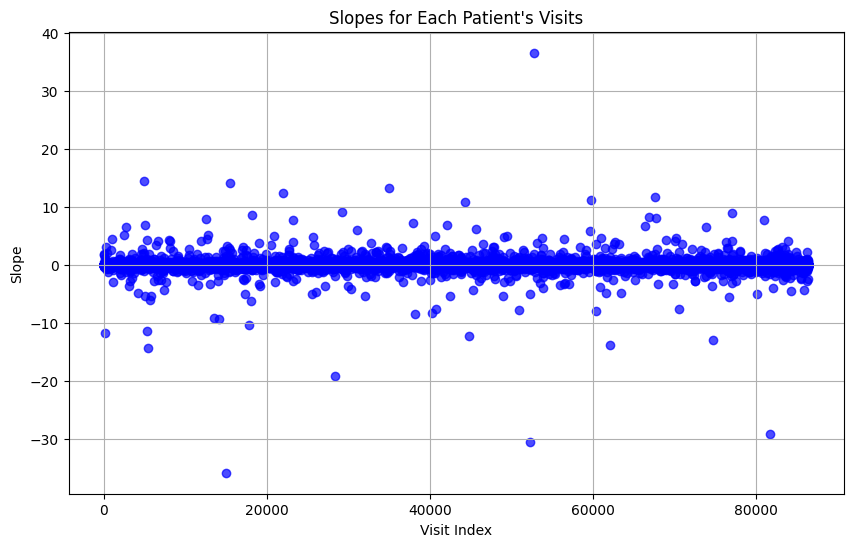

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ... Your previous code ...

# Collect data for plotting
x_values = []  # Visit indices
y_values = []  # Slopes

# Perform linear regression on each patient's data
for id, visits in dfBTW.items():
    for visit, data in visits.items():
        if len(data["eGFR"]) > 1 and data["slope"] is not None:
            slope = data["slope"]
            x_values.append(len(y_values) + 1)  # Index of visit
            y_values.append(slope)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.7)
plt.title("Slopes for Each Patient's Visits")
plt.xlabel("Visit Index")
plt.ylabel("Slope")
plt.grid(True)
plt.show()


In [51]:
import pandas as pd

# Create a list of DataFrames
dfs = []

# Iterate through dfBTW and create a DataFrame for each patient
for patient_id, visits in dfBTW.items():
    df_patient = pd.DataFrame.from_dict(visits, orient='index')
    df_patient['PatientID'] = patient_id
    dfs.append(df_patient)

# Concatenate the list of DataFrames into a single DataFrame
dfBTW_df = pd.concat(dfs)


In [52]:
dfBTW_df

,eGFR,timepoint,slope,intercept,PatientID
2016-08-15 09:51:54.913,"[71.7, 66.8]","[0, 87]",-0.056322,71.700000,2299
2017-03-31 10:18:54.363,"[67.20, 69.20]","[0, 96]",0.020833,67.200000,2299
2017-10-03 09:19:54.710,"[63.60, 58.40, 62.40]","[0, 92, 176]",-0.007605,62.146043,2299
2018-06-21 08:55:47.877,"[55.00, 64.00, 62.40, 70.20]","[0, 27, 83, 174]",0.070976,57.860722,2299
2019-03-13 09:13:31.170,"[73.50, 65.40]","[0, 98]",-0.082653,73.500000,2299
...,...,...,...,...,...
2022-12-14 11:30:53.310,"[47.44, 49.07]","[0, 90]",0.018111,47.440000,3421578
2022-11-29 10:47:37.917,"[27.88, 27.69]","[0, 100]",-0.001900,27.880000,3426284
2022-12-13 13:42:48.510,"[54.65, 44.30]","[0, 104]",-0.099519,54.650000,3431501
2022-12-15 09:48:31.117,"[70.18, 48.51, 67.71, 72.86, 68.69, 45.08]","[0, 25, 43, 46, 71, 116]",-0.141678,69.279199,3432056


#### 📍 **check**

> **np.isinf**




In [53]:
import numpy as np
import pandas as pd

# Assuming you have already calculated 'Slope' as shown in previous steps

# Find rows with infinite 'Slope' values
inf_rows = df_final[np.isinf(df_final['Slopes'])]
inf_indices = inf_rows.index

# Find rows immediately before the rows with infinite 'Slope' values
rows_before_inf = df_final[np.isinf(df_final['Slopes'].shift(-1))]

# Concatenate both DataFrames to get rows before and after 'inf_rows'
result = pd.concat([rows_before_inf, inf_rows])

# Print the resulting DataFrame
result

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes


In [54]:
dfBTW_df[dfBTW_df['slope'].isnull()] #cuz timepoint == 0

,eGFR,timepoint,slope,intercept,PatientID
2022-11-03 09:37:44.910,[79.14],[0],NaN,NaN,2299
2018-07-03 10:53:07.643,[63.00],[0],NaN,NaN,2304
2023-01-11 09:47:35.013,[58.40],[0],NaN,NaN,2304
2018-04-28 14:39:32.587,[57.60],[0],NaN,NaN,2312
2018-11-06 13:00:23.337,[78.00],[0],NaN,NaN,2312
...,...,...,...,...,...
2022-09-19 16:45:23.737,[22.87],[0],NaN,NaN,3395139
2023-03-27 07:34:21.283,[18.07],[0],NaN,NaN,3395139
2023-03-25 14:00:48.713,[69.10],[0],NaN,NaN,3396335
2023-04-05 08:24:44.890,[26.94],[0],NaN,NaN,3396748


In [55]:
df_final.isnull().any()

PatientUID         False
PatientVisitUID    False
CWhen              False
ResultItemName     False
ResultValue         True
date               False
datetime           False
TimeDiff            True
Slopes              True
dtype: bool

In [35]:
df_final[df_final['ResultValue'].isnull()] ## 7 rows >> ND/CC

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
101847,566187,8235036,2564-03-19 09:09:07.297,eGFR(CKD-EPI) age >=18,NaN,2021-03-19,2021-03-19 09:09:07.297,1.194521,NaN
213204,1269185,6082408,2562-03-13 09:40:29.180,eGFR(CKD-EPI) age >=18,NaN,2019-03-13,2019-03-13 09:40:29.180,NaN,NaN
215500,1289020,6842443,2562-11-15 12:28:30.490,eGFR(CKD-EPI) age >=18,NaN,2019-11-15,2019-11-15 12:28:30.490,1.271233,NaN
223639,1370560,6297595,2562-05-27 13:58:44.777,eGFR(CKD-EPI) age >=18,NaN,2019-05-27,2019-05-27 13:58:44.777,1.419178,NaN
235419,1480125,3615923,2559-11-02 10:43:49.273,eGFR(CKD-EPI) age >=18,NaN,2016-11-02,2016-11-02 10:43:49.273,NaN,NaN
240744,1523723,7139521,2564-01-06 14:54:19.083,eGFR(CKD-EPI) age >=18,NaN,2021-01-06,2021-01-06 14:54:19.083,3.824658,NaN
289352,2587904,5828463,2561-12-17 18:16:25.357,eGFR(CKD-EPI) age >=18,NaN,2018-12-17,2018-12-17 18:16:25.357,2.060274,NaN


In [36]:
df_final[df_final['TimeDiff'].isnull()] ## 20967 rows >> first Visit of each patient

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.70,2016-08-15,2016-08-15 09:51:54.913,NaN,NaN
30,2304,3431160,2559-08-30 09:37:00.867,eGFR(CKD-EPI) age >=18,68.90,2016-08-30,2016-08-30 09:37:00.867,NaN,NaN
45,2312,5136829,2561-04-28 14:39:32.587,eGFR(CKD-EPI) age >=18,57.60,2018-04-28,2018-04-28 14:39:32.587,NaN,NaN
65,2354,7003273,2563-01-09 07:57:21.190,eGFR(CKD-EPI) age >=18,56.99,2020-01-09,2020-01-09 07:57:21.190,NaN,NaN
78,2362,3910608,2560-02-20 19:48:50.243,eGFR(CKD-EPI) age >=18,67.60,2017-02-20,2017-02-20 19:48:50.243,NaN,NaN
...,...,...,...,...,...,...,...,...,...
318672,3421578,10151787,2565-12-14 11:30:53.310,eGFR(CKD-EPI) age >=18,47.44,2022-12-14,2022-12-14 11:30:53.310,NaN,NaN
318674,3426284,10105952,2565-11-29 10:47:37.917,eGFR(CKD-EPI) age >=18,27.88,2022-11-29,2022-11-29 10:47:37.917,NaN,NaN
318676,3431501,10144649,2565-12-13 13:42:48.510,eGFR(CKD-EPI) age >=18,54.65,2022-12-13,2022-12-13 13:42:48.510,NaN,NaN
318678,3432056,10154545,2565-12-15 09:48:31.117,eGFR(CKD-EPI) age >=18,70.18,2022-12-15,2022-12-15 09:48:31.117,NaN,NaN


In [37]:
df = pd.DataFrame(df_final)
result = df.dropna()
result

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
2,2299,4020970,2560-03-31 10:18:54.363,eGFR(CKD-EPI) age >=18,67.20,2017-03-31,2017-03-31 10:18:54.363,1.249315,-3.601974
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710,1.013699,-3.551351
7,2299,5296557,2561-06-21 08:55:47.877,eGFR(CKD-EPI) age >=18,55.00,2018-06-21,2018-06-21 08:55:47.877,1.424658,-6.036538
11,2299,6082911,2562-03-13 09:13:31.170,eGFR(CKD-EPI) age >=18,73.50,2019-03-13,2019-03-13 09:13:31.170,1.452055,12.740566
13,2299,6663614,2562-09-19 08:51:25.673,eGFR(CKD-EPI) age >=18,61.90,2019-09-19,2019-09-19 08:51:25.673,1.035616,-11.201058
...,...,...,...,...,...,...,...,...,...
318558,3392744,10499960,2566-03-20 18:06:58.147,eGFR(CKD-EPI) age >=18,50.64,2023-03-20,2023-03-20 18:06:58.147,1.024658,-27.453075
318566,3395139,10522595,2566-03-27 07:34:21.283,eGFR(CKD-EPI) age >=18,18.07,2023-03-27,2023-03-27 07:34:21.283,1.030137,-4.659574
318580,3396335,10520671,2566-03-25 14:00:48.713,eGFR(CKD-EPI) age >=18,69.10,2023-03-25,2023-03-25 14:00:48.713,1.013699,18.605135
318585,3396748,10559099,2566-04-05 08:24:44.890,eGFR(CKD-EPI) age >=18,26.94,2023-04-05,2023-04-05 08:24:44.890,1.068493,-5.587308


In [ ]:
# Save DataFrame to Excel file
#dfBTW_df.to_excel('SlopeBTW.xlsx', index=True)

In [ ]:
#df.to_excel('slope(keep null).xlsx')

In [ ]:
#result.to_excel('slope.xlsx')